<a href="https://colab.research.google.com/github/D0753192/Colab/blob/main/Stock_Project(single%2C_DWA%2CLSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model, optimizer_v1
from keras import Sequential,optimizers
from keras.layers import Dense, LSTM, Input, concatenate, Flatten,Dropout, Embedding, Concatenate
from keras.utils.vis_utils import plot_model
from keras import metrics
import math
from keras import callbacks
import datetime, os

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf

from matplotlib.font_manager import FontProperties

# 自定義字體變數
myfont = FontProperties(fname=r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')

# !!!!後續在相關函式中增加fontproperties=myfont屬性即可!!!!

--2021-12-08 07:36:17--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.73.206, 2607:f8b0:4004:829::200e
Connecting to drive.google.com (drive.google.com)|142.250.73.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n9gfs0vqpnl9d28v3cun9hi9bvk2hi60/1638948975000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-12-08 07:36:23--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n9gfs0vqpnl9d28v3cun9hi9bvk2hi60/1638948975000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.251.33.193, 2607:f8b0:4004:837::2001
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|142.251.33.193|

In [ ]:
def ZeroOneScaler(origin_data,data):
  return (origin_data - data.min()) / (data.max() - data.min())
def ZeroOneDeScaler(scale_data,data):
  return scale_data * (data.max() - data.min()) + data.min()

In [ ]:
stock_symbol = '23033'
time_step = 60
close_weight = 1.0
highest_weight = 1.0
lowest_weight = 1.0
volume_weight = 1.0
training_set_percent = 0.8
testing_set_percent = 0.2

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
#載入股票資訊
df = pd.read_csv(stock_symbol+'.csv')

In [ ]:
df

,Date,Trade Volume,Trade Value,Opening Price,Highest Price,Lowest Price,Closing Price,Change,Transaction
0,100104,30268635.0,5.150876e+08,17.2,17.2,16.8,17,-0.2,5747.0
1,100105,65133854.0,1.119637e+09,17.2,17.35,17.05,17.2,0.2,10198.0
2,100106,145046936.0,2.591783e+09,17.2,18.4,17.15,18.4,1.2,24535.0
3,100107,137964451.0,2.586912e+09,18.6,19.1,18.4,18.4,0.0,24566.0
4,100108,58947013.0,1.068333e+09,18.4,18.45,17.85,18.2,-0.2,11053.0
...,...,...,...,...,...,...,...,...,...
2843,210726,137792338.0,7.429437e+09,54,54.4,53.6,53.7,1.0,42572.0
2844,210727,118561484.0,6.355295e+09,54.2,54.3,53.1,53.1,-0.6,35962.0
2845,210728,199999316.0,1.026106e+10,52.4,52.6,50.5,51.8,-1.3,68871.0
2846,210729,437075578.0,2.376093e+10,53.9,55,53.3,54.6,2.8,132593.0


In [ ]:
df_sample = df[6:9].copy()

In [ ]:
df_sample

,Date,Trade Volume,Trade Value,Opening Price,Highest Price,Lowest Price,Closing Price,Change,Transaction
6,100112,54024017.0,993965162.0,18.60,18.85,18.15,18.35,-0.25,11941.0
7,100113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,100114,35850344.0,632602540.0,17.85,18.05,17.85,17.95,0.10,6691.0


In [ ]:
df_sample.dropna(subset=["Closing Price"],inplace=True)

In [ ]:
df_sample['Closing Price'] = ZeroOneScaler(df_sample['Closing Price'],train_set_close)
df_sample['Opening Price'] = ZeroOneScaler(df_sample['Opening Price'],train_set_close)
df_sample['Highest Price'] = ZeroOneScaler(df_sample['Highest Price'],train_set_highest)
df_sample['Lowest Price'] = ZeroOneScaler(df_sample['Lowest Price'],train_set_lowest)

In [ ]:
df_sample

,Date,Trade Volume,Trade Value,Opening Price,Highest Price,Lowest Price,Closing Price,Change,Transaction
6,100112,54024017.0,993965162.0,0.994186,0.971910,0.970519,0.965116,-0.25,11941.0
8,100114,35850344.0,632602540.0,0.906977,0.882022,0.935142,0.918605,0.10,6691.0


In [ ]:
sample_zero_one

6    0.965116
8    0.918605
Name: Closing Price, dtype: float64

In [ ]:
#檢查型態
#df.dtypes

In [ ]:
#檢查有無去掉雜值
#df.iloc[2093]

In [ ]:
#取得2020年範圍
#df = df[2465:2710]

In [ ]:
#將資料型態轉為float(number)
def changeDataType(df):
  df['Closing Price'] = pd.to_numeric(df['Closing Price'], errors='coerce')
  df['Highest Price'] = pd.to_numeric(df['Highest Price'], errors='coerce')
  df['Lowest Price'] = pd.to_numeric(df['Lowest Price'], errors='coerce')
  df['Opening Price'] = pd.to_numeric(df['Opening Price'], errors='coerce')
changeDataType(df)

In [ ]:
#去掉雜值
df.dropna(subset=["Closing Price"],inplace=True)

In [ ]:
data_length = len(df)
training_length = math.floor(data_length * training_set_percent)
testing_length = data_length - training_length

In [ ]:
data_length

2847

In [ ]:
training_length

2277

In [ ]:
testing_length

570

In [ ]:
def getStockData(df):
  df_close = df.iloc[:,6:7] #收盤價
  df_highest = df.iloc[:,4:5] #最高價
  df_lowest = df.iloc[:,5:6] #最低價
  #df_volume = df.iloc[:,1:2] #交易量
  return df, df_close, df_highest, df_lowest
df, df_close, df_highest, df_lowest = getStockData(df)

In [ ]:
#資料分堆(近10年)
def dataSegmentation(df):
  #前2200筆用作訓練,2200筆以後用作測試
  train_set_close = df_close[:training_length].values
  test_set_close = df_close[training_length:].values
  train_set_highest = df_highest[:training_length].values
  test_set_highest = df_highest[training_length:].values
  train_set_lowest = df_lowest[:training_length].values
  test_set_lowest = df_lowest[training_length:].values
  #train_set_volume = df_volume[:training_length].values
  #test_set_volume = df_volume[training_length:].values
  return train_set_close, test_set_close, train_set_highest, test_set_highest, train_set_lowest, test_set_lowest
train_set_close, test_set_close, train_set_highest, test_set_highest, train_set_lowest, test_set_lowest = dataSegmentation(df)
'''return train_set_close, test_set_close, train_set_highest, test_set_highest, train_set_lowest, test_set_lowest, train_set_volume, test_set_volume
train_set_close, test_set_close, train_set_highest, test_set_highest, train_set_lowest, test_set_lowest, train_set_volume, test_set_volume = dataSegmentation(df)'''

'return train_set_close, test_set_close, train_set_highest, test_set_highest, train_set_lowest, test_set_lowest, train_set_volume, test_set_volume\ntrain_set_close, test_set_close, train_set_highest, test_set_highest, train_set_lowest, test_set_lowest, train_set_volume, test_set_volume = dataSegmentation(df)'

In [ ]:
df_date = pd.to_datetime(df['Date'], format='%y%m%d') #將 Date 轉為 pd 的 datetime 格式

In [ ]:
#df_date

In [ ]:
#df.dtypes

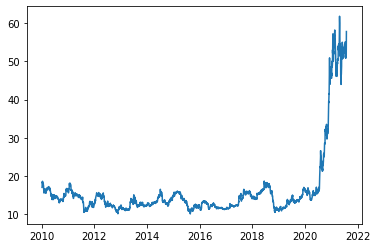

In [ ]:
#繪圖(收盤價)
plt.plot_date(df_date, df_close,fmt='-')

In [ ]:
train_set_scaled_close = ZeroOneScaler(train_set_close,train_set_close)
train_set_scaled_highest = ZeroOneScaler(train_set_highest,train_set_highest)
train_set_scaled_lowest = ZeroOneScaler(train_set_lowest,train_set_lowest)
#train_set_scaled_volume = ZeroOneScaler(train_set_volume,train_set_volume)

In [ ]:
def dataPreprocessing():
  x_train_close = []
  y_train_close = []
  x_train_highest = []
  y_train_highest = []
  x_train_lowest = []
  y_train_lowest = []
  #x_train_volume = []
  #y_train_volume = []
  for i in range(time_step,training_length): #以前time_step筆資料預測下一筆
      x_train_close.append(train_set_scaled_close[i-time_step:i,0])
      y_train_close.append(train_set_scaled_close[i,0])
      x_train_highest.append(train_set_scaled_highest[i-time_step:i,0])
      y_train_highest.append(train_set_scaled_highest[i,0])
      x_train_lowest.append(train_set_scaled_lowest[i-time_step:i,0])
      y_train_lowest.append(train_set_scaled_lowest[i,0])
      #x_train_volume.append(train_set_scaled_volume[i-time_step:i,0])
      #y_train_volume.append(train_set_scaled_volume[i,0])
  x_train_close = np.array(x_train_close)
  y_train_close = np.array(y_train_close)
  x_train_highest = np.array(x_train_highest)
  y_train_highest = np.array(y_train_highest)
  x_train_lowest = np.array(x_train_lowest)
  y_train_lowest = np.array(y_train_lowest)
  #x_train_volume = np.array(x_train_volume)
  #y_train_volume = np.array(y_train_volume)
  # 轉換成模型要求的維度
  x_train_close = np.reshape(x_train_close,(x_train_close.shape[0],x_train_close.shape[1],1))
  x_train_highest = np.reshape(x_train_highest,(x_train_highest.shape[0],x_train_highest.shape[1],1))
  x_train_lowest = np.reshape(x_train_lowest,(x_train_lowest.shape[0],x_train_lowest.shape[1],1))
  #x_train_volume = np.reshape(x_train_volume,(x_train_volume.shape[0],x_train_volume.shape[1],1))
  return x_train_close, y_train_close, x_train_highest, y_train_highest, x_train_lowest, y_train_lowest
x_train_close, y_train_close, x_train_highest, y_train_highest, x_train_lowest, y_train_lowest = dataPreprocessing()
'''return x_train_close, y_train_close, x_train_highest, y_train_highest, x_train_lowest, y_train_lowest, x_train_volume, y_train_volume
x_train_close, y_train_close, x_train_highest, y_train_highest, x_train_lowest, y_train_lowest, x_train_volume, y_train_volume = dataPreprocessing()'''

'return x_train_close, y_train_close, x_train_highest, y_train_highest, x_train_lowest, y_train_lowest, x_train_volume, y_train_volume\nx_train_close, y_train_close, x_train_highest, y_train_highest, x_train_lowest, y_train_lowest, x_train_volume, y_train_volume = dataPreprocessing()'

In [ ]:
def train_lstm():
  # LSTM訓練
  close_input = Input(shape=((time_step,1)), name='close_input')

  lstm1 = LSTM(units = 50,return_sequences=True)(close_input)
  drop1 = Dropout(0.2)(lstm1)
  lstm2 = LSTM(units = 50,return_sequences=True)(drop1)
  drop2 = Dropout(0.2)(lstm2)
  lstm3 = LSTM(units = 50,return_sequences=True)(drop2)
  drop3 = Dropout(0.2)(lstm3)
  lstm4 = LSTM(units = 50,return_sequences=True)(drop3)

  x=Flatten()(lstm4) 

  close = Dense(1,name='close')(x)
  highest = Dense(1,name='highest')(x)
  lowest = Dense(1,name='lowest')(x)
  #volume = Dense(1,name='volume')(x)

  reg = Model(inputs=close_input, outputs=[close, highest, lowest])

  reg.compile(
    optimizer = 'adam',
    loss={
        "close"   : 'mean_squared_error',
        "highest" : 'mean_squared_error',
        "lowest"  : 'mean_squared_error'
    },
    #loss_weights=[close_weight, highest_weight, lowest_weight, volume_weight],
    loss_weights=[close_weight, highest_weight, lowest_weight],
    metrics = []
  )
  return reg
reg = train_lstm()

In [ ]:
epoch_log=[]
weighting=[[],[],[]]
class MyCallback(callbacks.Callback):
  def __init__(self, close_weight, highest_weight, lowest_weight):
    self.close_weight = close_weight
    self.highest_weight = highest_weight
    self.lowest_weight = lowest_weight
    #self.volume_weight = volume_weight
    self.epoch_loss = [[],[],[]]
    
  def on_epoch_end(self, epoch, logs=None):
    keys = list(logs.keys())
    epoch_log.append(logs)
    
    self.epoch_loss[0].append(logs.get('close_loss'))
    self.epoch_loss[1].append(logs.get('highest_loss'))
    self.epoch_loss[2].append(logs.get('lowest_loss'))
    #self.epoch_loss[3].append(logs.get('volume_loss'))
    print("End epoch {} of training; got log keys: {}".format(epoch+1,keys))
    print("The epoch {} of training: got weight: {}".format(epoch+1,[self.close_weight,self.highest_weight,self.lowest_weight]))

    if epoch < 2:
      self.close_weight = close_weight
      self.highest_weight = highest_weight
      self.lowest_weight = lowest_weight
      #self.volume_weight = volume_weight
      
    else:
      #print("End epoch {} of training; got 2 closs_loss: {}".format(epoch,self.epoch_loss[0][epoch-2:epoch]))
      #print("End epoch {} of training; got 2 highest_log: {}".format(epoch,self.epoch_loss[1][epoch-2:epoch]))
      #print("End epoch {} of training; got 2 lowest_log: {}".format(epoch,self.epoch_loss[2][epoch-2:epoch]))
      #print("End epoch {} of training; got 2 volume_log: {}".format(epoch,self.epoch_loss[3][epoch-2:epoch]))
      w_close = self.epoch_loss[0][epoch-1] / self.epoch_loss[0][epoch-2]
      w_high = self.epoch_loss[1][epoch-1] / self.epoch_loss[1][epoch-2]
      w_low = self.epoch_loss[2][epoch-1] / self.epoch_loss[2][epoch-2]
      #w_vol = self.epoch_loss[3][epoch-1] / self.epoch_loss[3][epoch-2]
      self.close_weight = 3 * np.exp(w_close / 2) / (np.exp(w_close / 2) + np.exp(w_high / 2) + np.exp(w_low / 2))
      self.highest_weight = 3 * np.exp(w_high / 2) / (np.exp(w_close / 2) + np.exp(w_high / 2) + np.exp(w_low / 2))
      self.lowest_weight = 3 * np.exp(w_low / 2) / (np.exp(w_close / 2) + np.exp(w_high / 2) + np.exp(w_low / 2))
      #self.volume_weight = 4 * np.exp(w_vol / 2) / (np.exp(w_close / 2) + np.exp(w_high / 2) + np.exp(w_low / 2) + np.exp(w_vol / 2))

    weighting[0].append(self.close_weight)
    weighting[1].append(self.highest_weight)
    weighting[2].append(self.lowest_weight)
    #weighting[3].append(self.volume_weight)

In [ ]:
reg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 close_input (InputLayer)       [(None, 60, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 60, 50)       10400       ['close_input[0][0]']            
                                                                                                  
 dropout (Dropout)              (None, 60, 50)       0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 60, 50)       20200       ['dropout[0][0]']                
                                                                                              

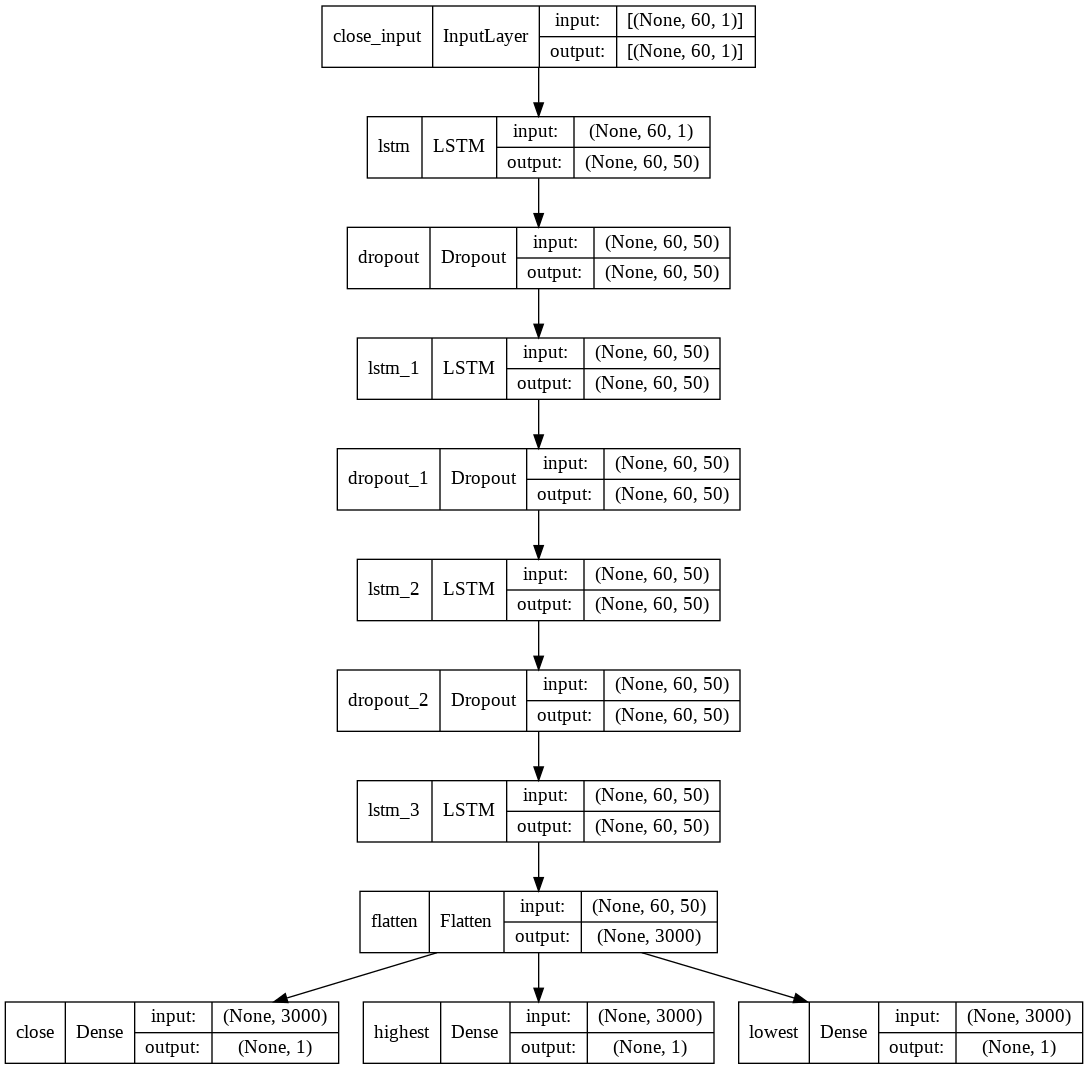

In [ ]:
plot_model(reg, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
reg.fit( x_train_close, [y_train_close,y_train_highest,y_train_lowest], epochs=100, batch_size=16,verbose=2, callbacks=[MyCallback(close_weight, highest_weight, lowest_weight), tensorboard_callback])

Epoch 1/100
End epoch 1 of training; got log keys: ['loss', 'close_loss', 'highest_loss', 'lowest_loss']
The epoch 1 of training: got weight: [1.0, 1.0, 1.0]
139/139 - 22s - loss: 0.0556 - close_loss: 0.0191 - highest_loss: 0.0178 - lowest_loss: 0.0187 - 22s/epoch - 156ms/step
Epoch 2/100
End epoch 2 of training; got log keys: ['loss', 'close_loss', 'highest_loss', 'lowest_loss']
The epoch 2 of training: got weight: [1.0, 1.0, 1.0]
139/139 - 13s - loss: 0.0217 - close_loss: 0.0077 - highest_loss: 0.0069 - lowest_loss: 0.0071 - 13s/epoch - 97ms/step
Epoch 3/100
End epoch 3 of training; got log keys: ['loss', 'close_loss', 'highest_loss', 'lowest_loss']
The epoch 3 of training: got weight: [1.0, 1.0, 1.0]
139/139 - 13s - loss: 0.0176 - close_loss: 0.0063 - highest_loss: 0.0056 - lowest_loss: 0.0058 - 13s/epoch - 97ms/step
Epoch 4/100
End epoch 4 of training; got log keys: ['loss', 'close_loss', 'highest_loss', 'lowest_loss']
The epoch 4 of training: got weight: [1.0053015703664372, 1.000

In [ ]:
history = reg.history.history

In [ ]:
#history

In [ ]:
input_close = df_close[len(df_close)-len(test_set_close)-time_step:].values
input_close = ZeroOneScaler(input_close,test_set_close)

input_highest = df_highest[len(df_highest)-len(test_set_highest)-time_step:].values
input_highest = ZeroOneScaler(input_highest,test_set_highest)

input_lowest = df_lowest[len(df_lowest)-len(test_set_lowest)-time_step:].values
input_lowest = ZeroOneScaler(input_lowest,test_set_lowest)

#input_volume = df_volume[len(df_volume)-len(test_set_volume)-time_step:].values
#input_volume = ZeroOneScaler(input_volume,test_set_volume)

In [ ]:
len(test_set_close)

570

In [ ]:
len(input_close)

630

In [ ]:
x_test_close = []
x_test_highest = []
x_test_lowest = []
#x_test_volume = []
y_test_close = []
y_test_highest = []
y_test_lowest = []
#y_test_volume = []
for i in range(time_step,len(input_close)):
    x_test_close.append(input_close[i-time_step:i,0])
    x_test_highest.append(input_highest[i-time_step:i,0])
    x_test_lowest.append(input_lowest[i-time_step:i,0])
    #x_test_volume.append(input_volume[i-time_step:i,0])
    y_test_close.append(input_close[i,0])
    y_test_highest.append(input_highest[i,0])
    y_test_lowest.append(input_lowest[i,0])
    #y_test_volume.append(input_volume[i,0])
y_test_close = np.array(y_test_close)
y_test_highest = np.array(y_test_highest)
y_test_lowest = np.array(y_test_lowest)
#y_test_volume = np.array(y_test_volume)

x_test_close = np.array(x_test_close)
x_test_close = np.reshape(x_test_close,(x_test_close.shape[0],x_test_close.shape[1],1))
x_test_highest = np.array(x_test_highest)
x_test_highest = np.reshape(x_test_highest,(x_test_highest.shape[0],x_test_highest.shape[1],1))
x_test_lowest = np.array(x_test_lowest)
x_test_lowest = np.reshape(x_test_lowest,(x_test_lowest.shape[0],x_test_lowest.shape[1],1))
#x_test_volume = np.array(x_test_volume)
#x_test_volume = np.reshape(x_test_volume,(x_test_volume.shape[0],x_test_volume.shape[1],1))
x_test_close.shape

(570, 60, 1)

In [ ]:
#len(pred[0])

In [ ]:
#len(pred_close)

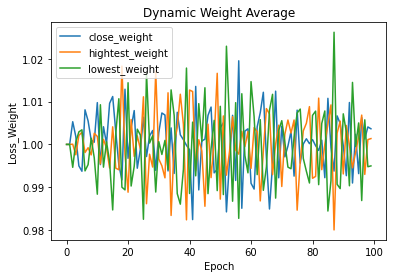

In [ ]:
plt.plot(weighting[0])
plt.plot(weighting[1])
plt.plot(weighting[2])

plt.title('Dynamic Weight Average')
plt.ylabel('Loss_Weight')
plt.xlabel('Epoch')
plt.legend(['close_weight', 'hightest_weight', 'lowest_weight'], loc='upper left')
#plt.legend(['close_weight', 'hightest_weight', 'lowest_weight', 'volume_weight'], loc='upper left')
plt.show()

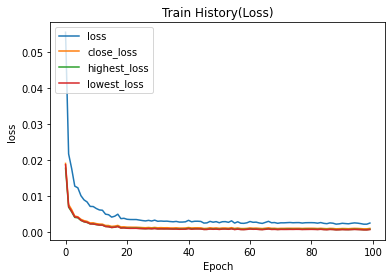

In [ ]:
plt.plot(reg.history.history['loss'])  
plt.plot(reg.history.history['close_loss'])
plt.plot(reg.history.history['highest_loss']) 
plt.plot(reg.history.history['lowest_loss']) 
#plt.plot(reg.history.history['volume_loss']) 
plt.title('Train History(Loss)')  
plt.ylabel('loss')  
plt.xlabel('Epoch')  
plt.legend(['loss', 'close_loss', 'highest_loss', 'lowest_loss'], loc='upper left')  
#plt.legend(['loss', 'close_loss', 'highest_loss', 'lowest_loss', 'volume_loss'], loc='upper left')  
plt.show()

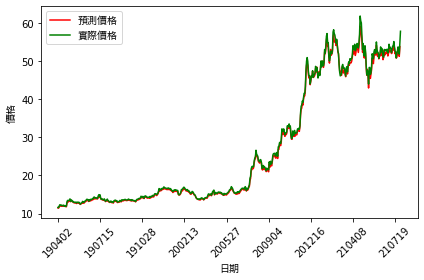

In [ ]:
pred = reg.predict(x_test_close)
#pred_close = model.inverse_transform(pred[0])
pred_close = ZeroOneDeScaler(pred[0],test_set_close)
df.loc[training_length:len(df)-1, 'pred_close'] = pred_close
df['pred_close'][training_length:].plot(color="red",label='預測價格')
ax = df['Closing Price'][training_length:].plot(color="green",label='實際價格')
plt.ylabel('價格',fontproperties=myfont)  
plt.xlabel('日期',fontproperties=myfont)
ax.set_xticks(df.index[training_length::70])
ax.set_xticklabels(df.Date[training_length::70], rotation=45)
plt.legend(loc='best',prop=myfont)
plt.tight_layout()
plt.savefig(stock_symbol+"_single_input_DWA_LSTM_"+str(time_step)+"days_all"+".png",dpi=3000)

In [ ]:
df['pred_close'][2664:2709].plot(color="red",label='預測價格')
ax = df['Closing Price'][2664:2709].plot(color="green",label='實際價格')
plt.ylabel('價格',fontproperties=myfont)  
plt.xlabel('日期',fontproperties=myfont)
ax.set_xticks(df.index[2664:2709:5])
ax.set_xticklabels(df.Date[2664:2709:5], rotation=45)
plt.legend(loc='best',prop=myfont)
plt.tight_layout()


In [ ]:
df['pred_close'][2810:].plot(color="red",label='預測價格')
ax = df['Closing Price'][2810:].plot(color="green",label='實際價格')
plt.ylabel('價格',fontproperties=myfont)  
plt.xlabel('日期',fontproperties=myfont)
ax.set_xticks(df.index[2810::3])
ax.set_xticklabels(df.Date[2810::3], rotation=45)
plt.legend(loc='best',prop=myfont)
plt.tight_layout()
plt.savefig(stock_symbol+"_single_input_DWA_LSTM_"+str(time_step)+"days"+".png",dpi=3000)

In [ ]:
'''pred = reg.predict(x_test_close)
pred_volume = ZeroOneDeScaler(pred[3],test_set_volume)
df.loc[training_length:len(df)-1, 'pred_volume'] = pred_volume
df['pred_volume'][training_length:].plot(color="red",label='預測成交量')
df['Trade Volume'][training_length:].plot(color="green",label='實際成交量')
plt.legend(loc='best',prop=myfont)'''

In [ ]:
'''df['pred_volume'][2664:2709].plot(color="red",label='預計成交量')
df['Trade Volume'][2664:2709].plot(color="green",label='實際成交量')
plt.legend(loc='best',prop=myfont)'''

In [ ]:
"""%load_ext tensorboard
%tensorboard --logdir logs"""

In [ ]:
MetaData = test_set_close
#MetaData = MetaData.reshape(len(MetaData),)

In [ ]:
PredData = ZeroOneDeScaler(pred[0],test_set_close)
#PredData = PredData.reshape(len(PredData))

In [ ]:
metrics.mape(MetaData.reshape(len(MetaData)), PredData.reshape(len(PredData)))

In [ ]:
metrics.mae(MetaData.reshape(len(MetaData)), PredData.reshape(len(PredData)))

In [ ]:
metrics.mse(MetaData.reshape(len(MetaData)), PredData.reshape(len(PredData)))

In [ ]:
math.sqrt(metrics.mse(MetaData.reshape(len(MetaData)), PredData.reshape(len(PredData))))

1.1062978594066437

1.1062978594066437